In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =0

nband = 1000

ng =11

ng_adju = (/ -2 , -2 /) 

ng_refs = (/ 2 , 3 , 6 /) 

nref =3

nv = 200

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 340

data w_diffuse
     &     /1.5 , 1.5 , 1.5 , 1.5,
     &     1.5 , 1.5 , 1.5 , 1.5,
     &     1.5 , 1.5 , 1.5/

data wgt
     &     /0.4 , 0.4 , 0.4 , 0.4,
     &     0.4 , 0.4 , 0.6 , 0.6,
     &     0.6 , 0.6 , 0.6/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

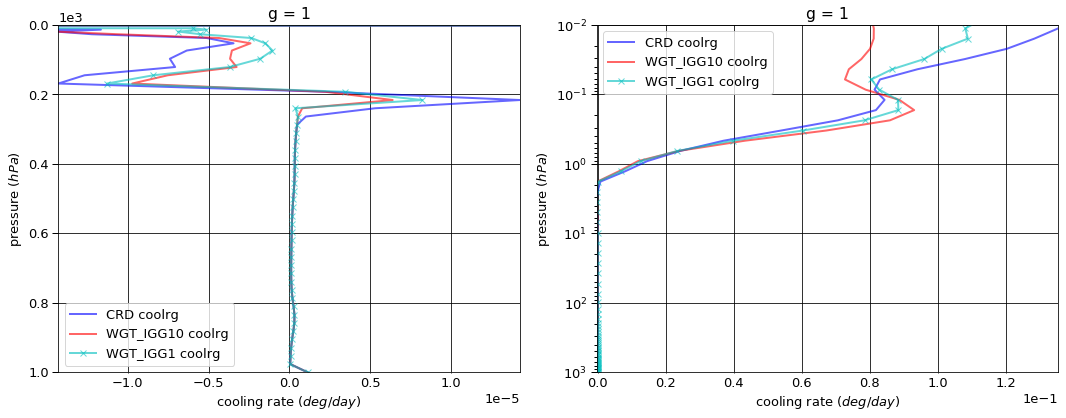

# Figure: cooling rate g-group 2

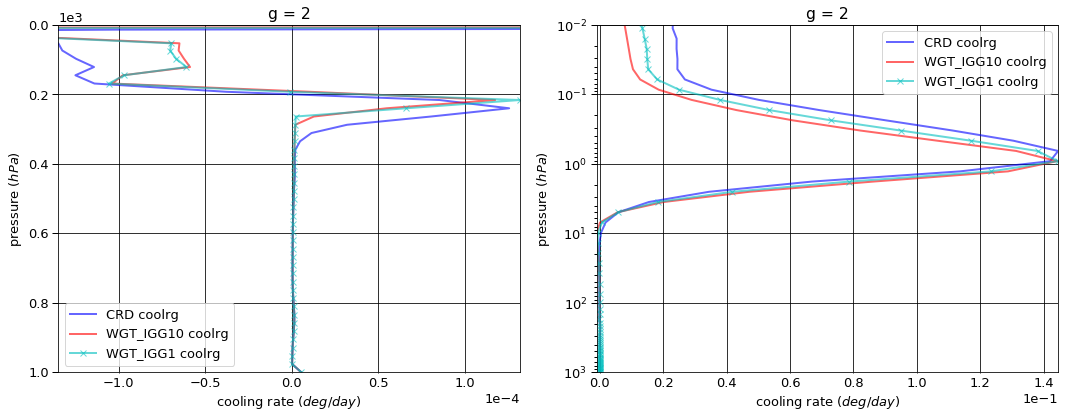

# Figure: cooling rate g-group 3

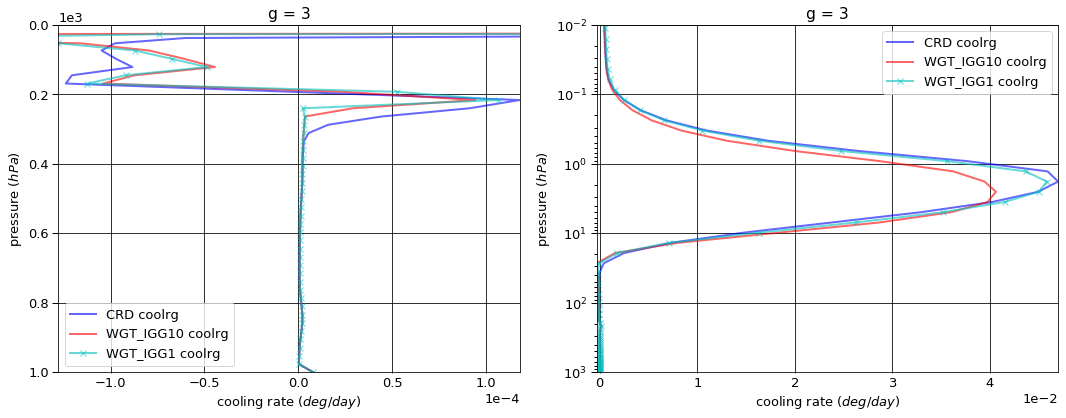

# Figure: cooling rate g-group 4

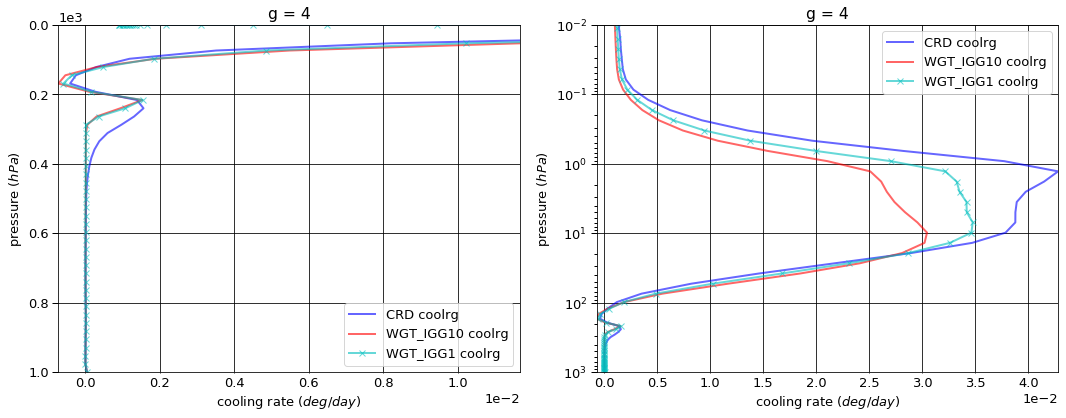

# Figure: cooling rate g-group 5

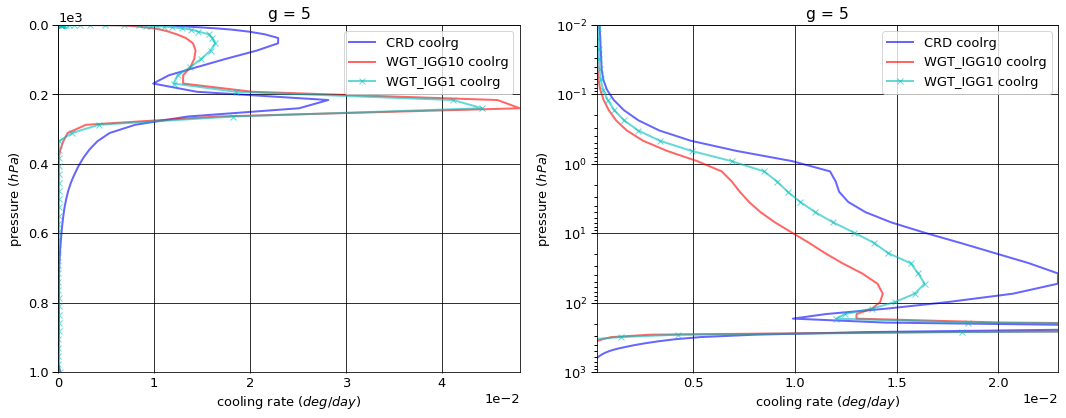

# Figure: cooling rate g-group 6

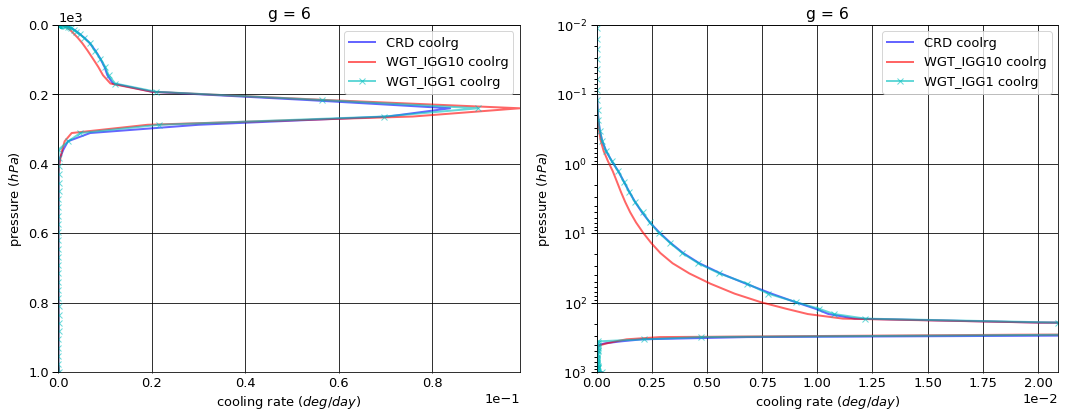

# Figure: cooling rate g-group 7

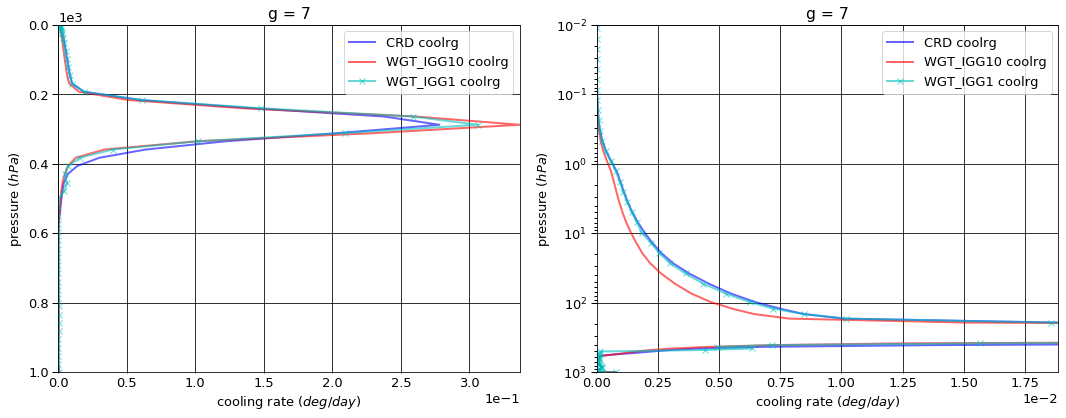

# Figure: cooling rate g-group 8

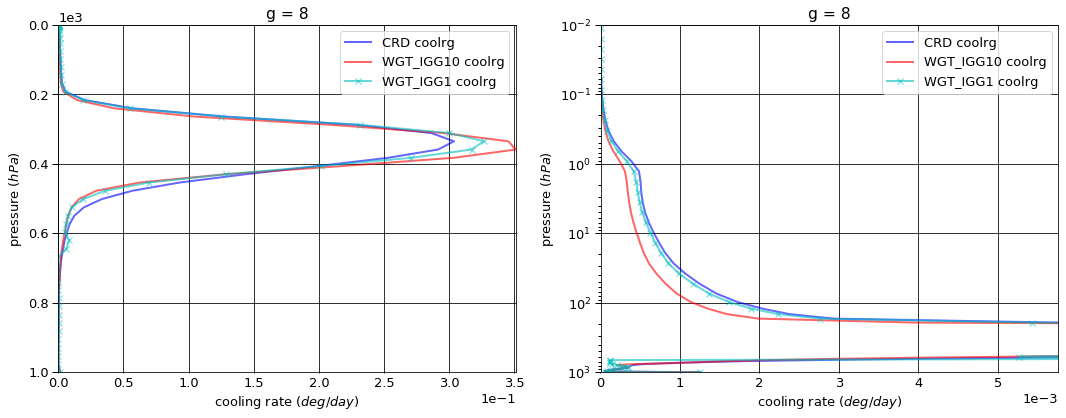

# Figure: cooling rate g-group 9

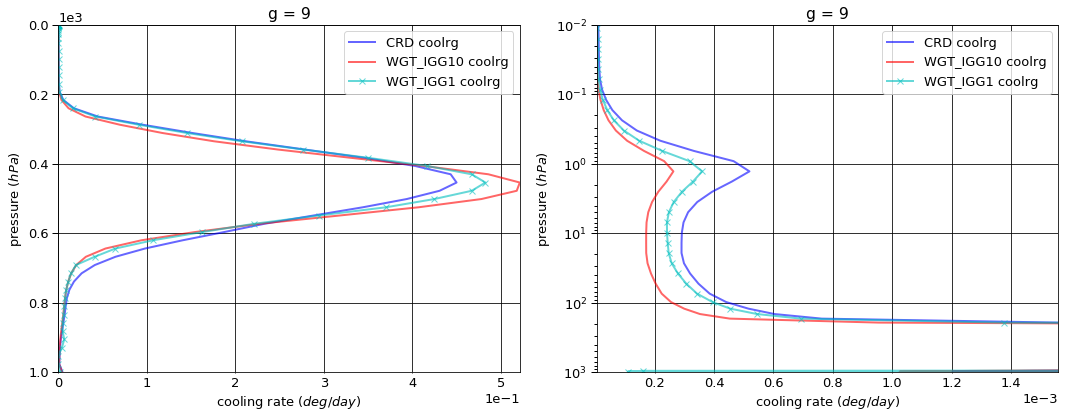

# Figure: cooling rate g-group 10

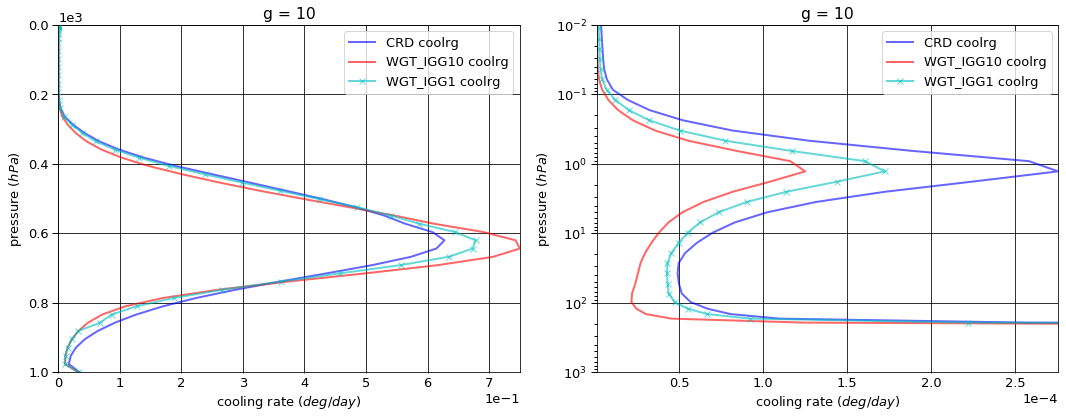

# Figure: cooling rate g-group 11

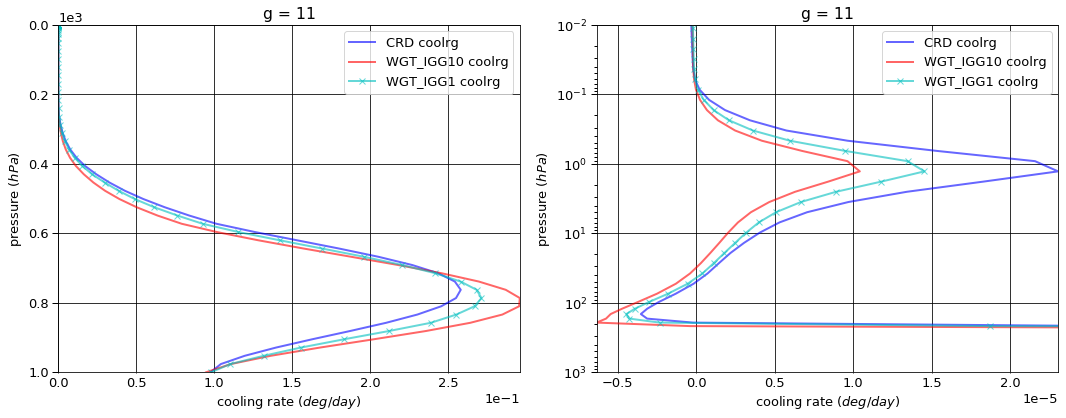

# Figure: cooling rate g-group total

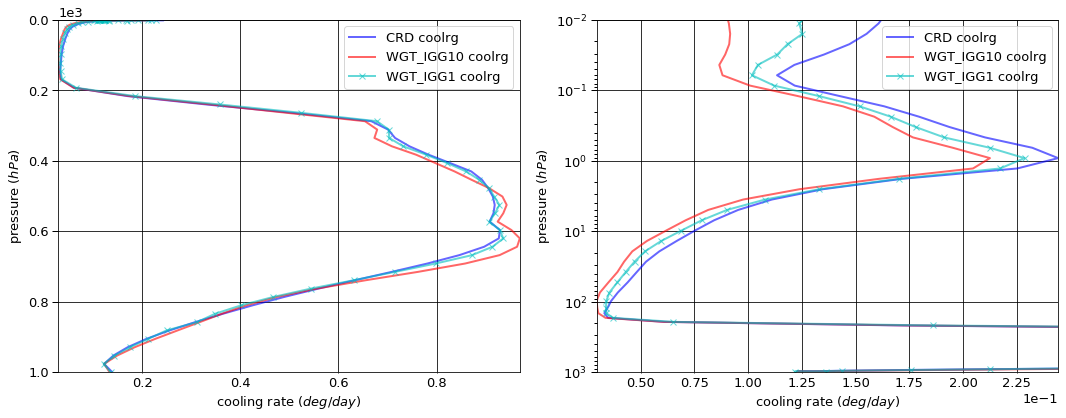

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005610   0.000000  -0.005610
   1013.0   76     -0.009312   0.009309  -0.000003
2  0.0      1      -0.030833   0.000000  -0.030833
   1013.0   76     -0.042357   0.042342  -0.000015
3  0.0      1      -0.042748   0.000000  -0.042748
   1013.0   76     -0.064365   0.064343  -0.000022
4  0.0      1      -0.187066   0.000000  -0.187066
   1013.0   76     -0.349362   0.349239  -0.000122
5  0.0      1      -0.682544   0.000000  -0.682544
   1013.0   76     -1.364499   1.363985  -0.000514
6  0.0      1      -0.932411   0.000000  -0.932411
   1013.0   76     -1.801958   1.801336  -0.000621
7  0.0      1      -3.492238   0.000000  -3.492238
   1013.0   76     -6.186713   6.184545  -0.002167
8  0.0      1      -6.142731   0.000000  -6.142731
   1013.0   76     -9.838320   9.834835  -0.003484
9  0.0      1     -13.470015   0.000000 -13.470015
   1013.0   76    -19.192648  19.180315  -0.012333
10 0.0      1     -23.634384   0.000000 -23.634384
   1013.0   76    -30.006619  29.899553  -0.107065
11 0.0      1     -11.694789   0.000000 -11.694789
   1013.0   76    -13.459642  12.627265  -0.832377


WGT_IGG10


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005623   0.000000  -0.005623
   1013.0   76     -0.009312   0.009309  -0.000003
2  0.0      1      -0.031913   0.000000  -0.031913
   1013.0   76     -0.042357   0.042342  -0.000015
3  0.0      1      -0.042606   0.000000  -0.042606
   1013.0   76     -0.064365   0.064343  -0.000022
4  0.0      1      -0.180178   0.000000  -0.180178
   1013.0   76     -0.349362   0.349239  -0.000122
5  0.0      1      -0.665416   0.000000  -0.665416
   1013.0   76     -1.364499   1.364020  -0.000479
6  0.0      1      -0.931212   0.000000  -0.931212
   1013.0   76     -1.801958   1.801336  -0.000621
7  0.0      1      -3.485196   0.000000  -3.485196
   1013.0   76     -6.186713   6.184545  -0.002167
8  0.0      1      -6.135493   0.000000  -6.135493
   1013.0   76     -9.838320   9.834835  -0.003484
9  0.0      1     -13.490488   0.000000 -13.490488
   1013.0   76    -19.192648  19.181386  -0.011262
10 0.0      1     -23.750155   0.000000 -23.750155
   1013.0   76    -30.006619  29.917419  -0.089200
11 0.0      1     -11.814028   0.000000 -11.814028
   1013.0   76    -13.459642  12.959005  -0.500638


WGT_IGG1


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.005572   0.000000  -0.005572
   1013.0   76     -0.009312   0.009309  -0.000003
2  0.0      1      -0.031571   0.000000  -0.031571
   1013.0   76     -0.042357   0.042342  -0.000015
3  0.0      1      -0.042979   0.000000  -0.042979
   1013.0   76     -0.064365   0.064343  -0.000022
4  0.0      1      -0.182396   0.000000  -0.182396
   1013.0   76     -0.349362   0.349239  -0.000122
5  0.0      1      -0.666347   0.000000  -0.666347
   1013.0   76     -1.364499   1.364020  -0.000479
6  0.0      1      -0.927619   0.000000  -0.927619
   1013.0   76     -1.801958   1.801336  -0.000621
7  0.0      1      -3.467515   0.000000  -3.467515
   1013.0   76     -6.186713   6.184545  -0.002167
8  0.0      1      -6.102297   0.000000  -6.102297
   1013.0   76     -9.838320   9.834835  -0.003484
9  0.0      1     -13.402854   0.000000 -13.402854
   1013.0   76    -19.192648  19.185668  -0.006980
10 0.0      1     -23.582076   0.000000 -23.582076
   1013.0   76    -30.006619  29.912402  -0.094216
11 0.0      1     -11.725979   0.000000 -11.725979
   1013.0   76    -13.459642  12.855107  -0.604536


WGT_IGG10 - CRD


flug          fldg     fnetg
g  pressure level                                      
1  0.0      1     -1.307170e-05  0.000000e+00 -0.000013
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
2  0.0      1     -1.080229e-03  0.000000e+00 -0.001080
   1013.0   76     0.000000e+00 -6.938894e-18  0.000000
3  0.0      1      1.422280e-04  0.000000e+00  0.000142
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
4  0.0      1      6.888080e-03  0.000000e+00  0.006888
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
5  0.0      1      1.712831e-02  0.000000e+00  0.017128
   1013.0   76     0.000000e+00  3.500000e-05  0.000035
6  0.0      1      1.199070e-03  0.000000e+00  0.001199
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
7  0.0      1      7.041900e-03  0.000000e+00  0.007042
   1013.0   76     0.000000e+00 -8.881784e-16  0.000000
8  0.0      1      7.237300e-03  0.000000e+00  0.007237
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
9  0.0      1     -2.047300e-02  0.000000e+00 -0.020473
   1013.0   76     3.552714e-15  1.071000e-03  0.001071
10 0.0      1     -1.157710e-01  0.000000e+00 -0.115771
   1013.0   76     0.000000e+00  1.786600e-02  0.017866
11 0.0      1     -1.192390e-01  0.000000e+00 -0.119239
   1013.0   76     0.000000e+00  3.317400e-01  0.331740


WGT_IGG1 - CRD


flug          fldg     fnetg
g  pressure level                                      
1  0.0      1      3.882240e-05  0.000000e+00  0.000039
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
2  0.0      1     -7.383090e-04  0.000000e+00 -0.000738
   1013.0   76     0.000000e+00 -6.938894e-18  0.000000
3  0.0      1     -2.310280e-04  0.000000e+00 -0.000231
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
4  0.0      1      4.670190e-03  0.000000e+00  0.004670
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
5  0.0      1      1.619660e-02  0.000000e+00  0.016197
   1013.0   76     0.000000e+00  3.500000e-05  0.000035
6  0.0      1      4.792680e-03  0.000000e+00  0.004793
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
7  0.0      1      2.472290e-02  0.000000e+00  0.024723
   1013.0   76     0.000000e+00 -8.881784e-16  0.000000
8  0.0      1      4.043400e-02  0.000000e+00  0.040434
   1013.0   76     0.000000e+00  0.000000e+00  0.000000
9  0.0      1      6.716100e-02  0.000000e+00  0.067161
   1013.0   76     3.552714e-15  5.353000e-03  0.005353
10 0.0      1      5.230800e-02  0.000000e+00  0.052308
   1013.0   76     0.000000e+00  1.284900e-02  0.012849
11 0.0      1     -3.119000e-02  0.000000e+00 -0.031190
   1013.0   76     0.000000e+00  2.278420e-01  0.227842

# Table: cooling rate. g-groups 


CRD


coolrg
g  pressure    layer              
1  0.000312    1      1.366357e-01
   1001.112500 75     1.121112e-06
2  0.000312    1      1.652764e-02
   1001.112500 75     5.560166e-06
3  0.000312    1      2.279429e-04
   1001.112500 75     8.007919e-06
4  0.000312    1      9.737327e-04
   1001.112500 75     4.421842e-05
5  0.000312    1      2.942058e-04
   1001.112500 75     1.856869e-04
6  0.000312    1      1.712514e-06
   1001.112500 75     2.244871e-04
7  0.000312    1      5.453598e-06
   1001.112500 75     7.829797e-04
8  0.000312    1      6.469248e-06
   1001.112500 75     1.258684e-03
9  0.000312    1      6.854949e-06
   1001.112500 75     4.869643e-03
10 0.000312    1      8.752021e-07
   1001.112500 75     3.459302e-02
11 0.000312    1     -4.773480e-07
   1001.112500 75     9.761873e-02


WGT_IGG10


coolrg
g  pressure    layer              
1  0.000312    1      6.733789e-02
   1001.112500 75     1.121112e-06
2  0.000312    1      3.618579e-03
   1001.112500 75     5.560166e-06
3  0.000312    1      3.133948e-04
   1001.112500 75     8.007919e-06
4  0.000312    1      7.602989e-04
   1001.112500 75     4.421842e-05
5  0.000312    1      1.942799e-04
   1001.112500 75     1.729994e-04
6  0.000312    1      1.269374e-06
   1001.112500 75     2.244871e-04
7  0.000312    1      3.873608e-06
   1001.112500 75     7.829797e-04
8  0.000312    1      3.395281e-06
   1001.112500 75     1.258685e-03
9  0.000312    1      2.902755e-06
   1001.112500 75     4.449471e-03
10 0.000312    1     -3.823876e-07
   1001.112500 75     3.225751e-02
11 0.000312    1     -3.046228e-07
   1001.112500 75     9.477887e-02


WGT_IGG1


coolrg
g  pressure    layer              
1  0.000312    1      1.013920e-01
   1001.112500 75     1.121112e-06
2  0.000312    1      7.720394e-03
   1001.112500 75     5.560166e-06
3  0.000312    1      3.395845e-04
   1001.112500 75     8.007919e-06
4  0.000312    1      8.957054e-04
   1001.112500 75     4.421842e-05
5  0.000312    1      2.563442e-04
   1001.112500 75     1.729994e-04
6  0.000312    1      1.740281e-06
   1001.112500 75     2.244871e-04
7  0.000312    1      5.495603e-06
   1001.112500 75     7.829797e-04
8  0.000312    1      5.009873e-06
   1001.112500 75     1.258685e-03
9  0.000312    1      4.968037e-06
   1001.112500 75     2.521216e-03
10 0.000312    1      3.832041e-07
   1001.112500 75     3.311799e-02
11 0.000312    1     -3.134848e-07
   1001.112500 75     9.795554e-02


WGT_IGG10 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -6.929782e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -1.290906e-02
   1001.112500 75     0.000000e+00
3  0.000312    1      8.545184e-05
   1001.112500 75     0.000000e+00
4  0.000312    1     -2.134337e-04
   1001.112500 75    -6.776264e-21
5  0.000312    1     -9.992588e-05
   1001.112500 75    -1.268749e-05
6  0.000312    1     -4.431398e-07
   1001.112500 75     2.710505e-20
7  0.000312    1     -1.579991e-06
   1001.112500 75     0.000000e+00
8  0.000312    1     -3.073967e-06
   1001.112500 75     2.168404e-19
9  0.000312    1     -3.952195e-06
   1001.112500 75    -4.201725e-04
10 0.000312    1     -1.257590e-06
   1001.112500 75    -2.335511e-03
11 0.000312    1      1.727253e-07
   1001.112500 75    -2.839864e-03


WGT_IGG1 - CRD


coolrg
g  pressure    layer              
1  0.000312    1     -3.524372e-02
   1001.112500 75     0.000000e+00
2  0.000312    1     -8.807244e-03
   1001.112500 75     0.000000e+00
3  0.000312    1      1.116416e-04
   1001.112500 75     0.000000e+00
4  0.000312    1     -7.802727e-05
   1001.112500 75    -6.776264e-21
5  0.000312    1     -3.786162e-05
   1001.112500 75    -1.268749e-05
6  0.000312    1      2.776740e-08
   1001.112500 75     2.710505e-20
7  0.000312    1      4.200450e-08
   1001.112500 75     0.000000e+00
8  0.000312    1     -1.459375e-06
   1001.112500 75     2.168404e-19
9  0.000312    1     -1.886913e-06
   1001.112500 75    -2.348427e-03
10 0.000312    1     -4.919980e-07
   1001.112500 75    -1.475036e-03
11 0.000312    1      1.638632e-07
   1001.112500 75     3.368060e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.315369,0.000000,-60.315369
1013.0,76,-82.315794,81.357068,-0.958727



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.532308,0.00000,-60.532308
1013.0,76,-82.315794,81.70778,-0.608015



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-60.137204,0.000000,-60.137204
1013.0,76,-82.315794,81.603147,-0.712647



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.216939,0.000000,-0.216939
1013.0,76,0.000000,0.350712,0.350712



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.178165,0.000000,0.178165
1013.0,76,0.000000,0.246079,0.246079


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.154680
1001.112500,75,0.139592



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.072235
1001.112500,75,0.133984



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.110621
1001.112500,75,0.136093



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.082445
1001.112500,75,-0.005608



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.044059
1001.112500,75,-0.003499


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.000125,0.000119
2,0.000525,0.000521
3,0.000840,0.000810
4,0.004490,0.004364
5,0.017520,0.017032
6,0.023475,0.022653
7,0.079385,0.077276
8,0.125500,0.122349
9,0.238215,0.235985


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.013979e-17
2,7.376594e-19
3,4.606445e-19
4,3.437534e-20
5,2.565240e-21
6,2.180272e-20
7,3.897251e-21
8,6.966363e-22
9,1.245242e-22


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.013979e-17,NaN,0.000125,0.000119,0.000125,0.000119,1.0
2,7.376594e-19,0.072749,0.000525,0.000521,0.000650,0.000640,1.0
3,4.606445e-19,0.624468,0.000840,0.000810,0.001490,0.001449,10.0
4,3.437534e-20,0.074624,0.004490,0.004364,0.005980,0.005813,10.0
5,2.565240e-21,0.074624,0.017520,0.017032,0.023500,0.022845,10.0
6,2.180272e-20,8.499291,0.023475,0.022653,0.046975,0.045498,500.0
7,3.897251e-21,0.178751,0.079385,0.077276,0.126360,0.122774,500.0
8,6.966363e-22,0.178751,0.125500,0.122349,0.251860,0.245123,500.0
9,1.245242e-22,0.178751,0.238215,0.235985,0.490075,0.481108,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
